In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import pandas as pd
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import time
%matplotlib inline
import trap_util as tu
from trap_util import trap
from trap_util import quarter_trap
from trap_util import half_trap
# physical parameters
q = -1.60217662e-19 # coulombs
m = 9.10938356e-31 #kg (electron)
kB = 1.38064852e-23 # J/K
ramp_time = 5.0e-9 #s (the ramping time for extraction voltage)
f = 1.5e9 # Electrode frequency, in Hertz

In [2]:
# event_log = []

## Reading E-field data

In [2]:
# loading RF E field data
data_RF = np.loadtxt("../etrap_65V_1p5GHz_realsmoothExEy_250nm_30passes_quarter.fld", skiprows = 2)

In [3]:
data_DC0 = np.loadtxt("3D_no_ext_voltage_radial_plane_fix_all_multipoles_except_constant.fld", skiprows=2)

In [4]:
data_DC1 = np.loadtxt("ext_voltage_x02_y-2_9.5.fld", skiprows=2)

In [5]:
# manipulating E field data
df_DC0 = pd.DataFrame(data_DC0, columns=['x', 'z', 'y', 'Ex', 'Ez', 'Ey'])
# dealing with the discrepency between axis notations used by this simulation and Maxwell
df_DC0 = df_DC0[["x", "y", "z", "Ex", "Ey", "Ez"]]
#df_DC0[(abs(df_DC0.y)<50.0e-6) & (df_DC0.x==0) & (abs(df_DC0.Ey)<10.0)]

In [6]:
x_max_DC0, x_min_DC0 = df_DC0.x.max(), df_DC0.x.min()
y_max_DC0, y_min_DC0 = df_DC0.y.max(), df_DC0.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx_DC0, Ny_DC0 = df_DC0.x.nunique() - 1, df_DC0.y.nunique() - 1 # numbers of intervals that divide each dimension
dx_DC0, dy_DC0 = (x_max_DC0-x_min_DC0)/Nx_DC0, (y_max_DC0-y_min_DC0)/Ny_DC0 # interval size
print("x_max = ", x_max_DC0*1.0e3, "mm")
print("y_max = ", y_max_DC0*1.0e3, "mm")
print("x_min = ", x_min_DC0*1.0e3, "mm")
print("y_min = ", y_min_DC0*1.0e3, "mm")
print("spatial resolution x: ", dx_DC0*1.0e6, "um")
print("spatial resolution y: ", dy_DC0*1.0e6, "um")
print("----------")
# manipulating E field data
df_DC1 = pd.DataFrame(data_DC1, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
x_max_DC1, x_min_DC1 = df_DC1.x.max(), df_DC1.x.min()
y_max_DC1, y_min_DC1 = df_DC1.y.max(), df_DC1.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx_DC1, Ny_DC1 = df_DC1.x.nunique() - 1, df_DC1.y.nunique() - 1 # numbers of intervals that divide each dimension
dx_DC1, dy_DC1 = (x_max_DC1-x_min_DC1)/Nx_DC1, (y_max_DC1-y_min_DC1)/Ny_DC1 # interval size
print("x_max = ", x_max_DC1*1.0e3, "mm")
print("y_max = ", y_max_DC1*1.0e3, "mm")
print("x_min = ", x_min_DC1*1.0e3, "mm")
print("y_min = ", y_min_DC1*1.0e3, "mm")
print("spatial resolution x: ", dx_DC1*1.0e6, "um")
print("spatial resolution y: ", dy_DC1*1.0e6, "um")

x_max =  2.0 mm
y_max =  2.0 mm
x_min =  0.0 mm
y_min =  -2.0 mm
spatial resolution x:  1.0 um
spatial resolution y:  1.0 um
----------
x_max =  2.0 mm
y_max =  9.500000000000002 mm
x_min =  0.0 mm
y_min =  -2.0 mm
spatial resolution x:  5.0 um
spatial resolution y:  5.0 um


In [7]:
# manipulating E field data
df_RF = pd.DataFrame(data_RF, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
x_max_RF, x_min_RF = df_RF.x.max(), df_RF.x.min()
y_max_RF, y_min_RF = df_RF.y.max(), df_RF.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx_RF, Ny_RF = df_RF.x.nunique() - 1, df_RF.y.nunique() - 1 # numbers of intervals that divide each dimension
dx_RF, dy_RF = (x_max_RF-x_min_RF)/Nx_RF, (y_max_RF-y_min_RF)/Ny_RF # interval size
print("x_max = ", x_max_RF*1.0e3, "mm")
print("y_max = ", y_max_RF*1.0e3, "mm")
print("x_min = ", x_min_RF*1.0e3, "mm")
print("y_min = ", y_min_RF*1.0e3, "mm")
print("spatial resolution x: ", dx_RF*1.0e6, "um")
print("spatial resolution y: ", dy_RF*1.0e6, "um")

x_max =  1.0 mm
y_max =  1.5 mm
x_min =  0.0 mm
y_min =  0.0 mm
spatial resolution x:  0.25 um
spatial resolution y:  0.25 um


## Initializing DC and RF Trap Objects

In [8]:
trap_RF = quarter_trap(df_RF, x_max_RF, x_min_RF, y_max_RF, y_min_RF,\
                      Nx_RF, Ny_RF, dx_RF, dy_RF, f=f)
trap_DC0 = half_trap(df_DC0, x_max_DC0, x_min_DC0, y_max_DC0, y_min_DC0,\
                      Nx_DC0, Ny_DC0, dx_DC0, dy_DC0, f=0.0)
trap_DC1 = half_trap(df_DC1, x_max_DC1, x_min_DC1, y_max_DC1, y_min_DC1,\
                      Nx_DC1, Ny_DC1, dx_DC1, dy_DC1, f=0.0)

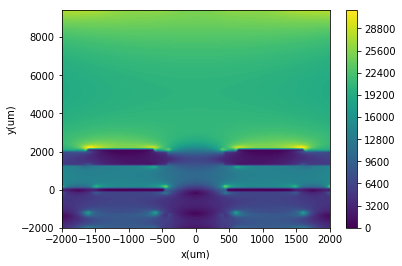

In [9]:
x = np.linspace(-2.0e-3, 2.0e-3, 101)
y = np.linspace(-2.0e-3, 9.4e-3, 101)
X, Y = np.meshgrid(x, y)
E = np.zeros_like(X)
for j in range(len(y)):
    for i in range(len(x)):
        Ex, Ey = trap_DC1.E_field(x[i], y[j], 0)
        E[j][i] = np.sqrt(Ex**2 + Ey**2)
plt.contourf(X*1.0e6, Y*1.0e6, E, 200)
plt.xlabel("x(um)")
plt.ylabel("y(um)")
plt.colorbar()

## Defining simulation functions (RF + a time weighted linear combination of DC voltages )

0.729996294002817

In [82]:
def E_field_sim(state, time, RF_phase=0):
    # this is a function that takes in a 2-element array state and a number time.
    # state[0] is current position and state[1] is current velocity.
    # it calculates the derivative of state, and returns a 2-element array,
    # with the 0th element being derivative of position and the 1th being 
    # the acceleration
    ramp_time = 12.0e-9
    factor = 0.75
    g0 = state[1]
    x, y = state[0] 
    def RF_ac(x, y, time):
        if y > trap_RF.y_max:
            return 0
        else:
            return trap_RF.acceleration(x, y, time+RF_phase/(2*np.pi*f))
    if time < ramp_time:
        g1 = RF_ac(x, y, time) + (1 - time/ramp_time) * trap_DC0.acceleration(x, y, time) +\
        time/ramp_time * factor * trap_DC1.acceleration(x, y ,time)
    else:
        g1 = RF_ac(x, y, time) + factor * trap_DC1.acceleration(x, y, time)
    #g1 = trap_RF.acceleration(x, y, time) + trap_DC0.acceleration(x, y, time)
    return np.array([g0, g1])

def rk4(y, time, dt, derivs, RF_phase=0): 
    f0 = derivs(y, time, RF_phase)
    fhalf_bar = derivs(y+f0*dt/2, time+dt, RF_phase)
    fhalf = derivs(y+fhalf_bar*dt/2, time+dt, RF_phase)
    f1_bar= derivs(y+fhalf*dt, time+dt, RF_phase)
    y_next = y+dt/6*(f0+2*fhalf_bar+2*fhalf+f1_bar)
    return y_next

def extracted(rho, phi, v, theta, dt, t_max):
    electron_pos=np.array([rho*np.cos(phi), rho*np.sin(phi)])
    electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
    state = np.array([electron_pos, electron_vel])
    t = 0.0 # the time variable
    extracted = False
    # if the electron is successfully extracted, return the actual arrival time
    # otherwise, return -1.0 as the arrival time
    t_arrival = -1.0
    RF_phase = np.random.rand() * 2*np.pi
    
    # actual simulation
    while t < t_max:
        x, y = state[0]
        if trap_DC1.hit_electrodes(x, y):
            break
        if y > trap_DC1.y_max:
            extracted = True
            t_arrival = t
            break
        if not trap_DC1.within_boundary(x, y):
            break
        state = rk4(state, t, dt, E_field_sim, RF_phase)
        t += dt
    return extracted, x, y, t_arrival

def traj(rho, phi, v, theta, dt, t_max):
    electron_pos=np.array([rho*np.cos(phi), rho*np.sin(phi)])
    electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
    state = np.array([electron_pos, electron_vel])
    t = 0.0 # the time variable
    extracted = False
    xs, ys, ts = [], [], []
    # if the electron is successfully extracted, return the actual arrival time
    # otherwise, return -1.0 as the arrival time
    t_arrival = -1.0 
    RF_phase = np.random.rand() * 2*np.pi
    # actual simulation
    while t < t_max:
        x, y = state[0]
        xs.append(x)
        ys.append(y)
        ts.append(t)
        if trap_DC1.hit_electrodes(x, y):
            break
        if y > trap_DC1.y_max:
            extracted = True
            t_arrival = t
            break
        if not trap_DC1.within_boundary(x, y):
            break
        state = rk4(state, t, dt, E_field_sim, RF_phase)
        t += dt
    return extracted, np.array(ts), np.array(xs), np.array(ys), t_arrival

def Boltzmann_sim(N_samples, T, dt, t_max, FWHM):
    class Boltzmann(stats.rv_continuous):
        def _pdf(self, v):
            return m*v*np.exp((-1/2*m*v**2)/(kB*T))/(kB*T)
    result, x_trajs, y_trajs, t_s, t_arrivals = [], [], [], [], []
    Boltzmann_dist = Boltzmann(a=0)
    for i in range(N_samples):
        rho = abs(np.random.normal(0, FWHM/2.355))
        phi = np.random.uniform(0, np.pi*2)
        v = Boltzmann_dist.rvs()
        theta = np.random.uniform(0, np.pi*2)
        success, ts, xs, ys, t_arrival = traj(rho, phi, v, theta, dt, t_max)
        result.append(success)
        t_s.append(ts)
        x_trajs.append(xs)
        y_trajs.append(ys)
        t_arrivals.append(t_arrival)
        if i % 20 == 0:
            print(i+1, " samples already simulated")
    return result, t_s, x_trajs, y_trajs, t_arrivals

def fixedT_sim(N_samples, T, dt, t_max, FWHM):
    result, x_trajs, y_trajs, t_s, t_arrivals = [], [], [], [], []
    for i in range(N_samples):
        rho = abs(np.random.normal(0, FWHM/2.355))
        phi = np.random.uniform(0, np.pi*2)
        v = np.sqrt(2*kB*T/m)
        theta = np.random.uniform(0, np.pi*2)
        success, ts, xs, ys, t_arrival = traj(rho, phi, v, theta, dt, t_max)
        result.append(success)
        t_s.append(ts)
        x_trajs.append(xs)
        y_trajs.append(ys)
        t_arrivals.append(t_arrival)
#         if i % 200 == 199:
#             print(i+1, " samples already simulated")
    return result, t_s, x_trajs, y_trajs, np.array(t_arrivals)

## Histogram of arrival time

In [83]:
# t_arrival_dict = dict() # key: (T, FWHM); elements: a list of t_arrivals

### 50K

(8.0, 11.0)

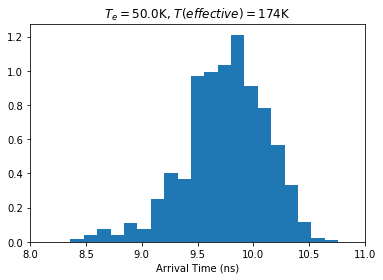

In [99]:
N = 1000
T = 50.0 # Kelvin
dt = 1.0e-11 #s
t_max = 250.0e-9 # maximum time duration of the simulation
FWHM = 100.0e-6
bins = np.linspace(8, 11, 26)
result, t_s, x_trajs, y_trajs, t_arrivals = fixedT_sim(N, T, dt, t_max, FWHM)
if (T, FWHM) not in t_arrival_dict:
    t_arrival_dict[(T, FWHM)] = []
t_arrival_dict[(T, FWHM)] += list(t_arrivals) 
# Plotting
omega_trap = 2*np.pi*230.0e6 # Hz
U_avg = 0.5*m*(omega_trap)**2*(FWHM/2.355)**2
T_eff = U_avg/kB + T
plt.hist(t_arrivals*1.0e9, bins=bins, density=True)
plt.xlabel("Arrival Time (ns)")
plt.title("$T_e = {}$K, $T(effective) = {}$K".format(T, round(T_eff)))
plt.xlim(bins[0], bins[-1])

### 100K

(8.0, 11.0)

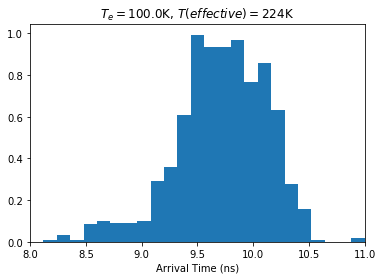

In [100]:
N = 1000
T = 100.0 # Kelvin
dt = 1.0e-11 #s
t_max = 250.0e-9 # maximum time duration of the simulation
FWHM = 100.0e-6
bins = np.linspace(8, 11, 26)
result, t_s, x_trajs, y_trajs, t_arrivals = fixedT_sim(N, T, dt, t_max, FWHM)
if (T, FWHM) not in t_arrival_dict:
    t_arrival_dict[(T, FWHM)] = []
t_arrival_dict[(T, FWHM)] += list(t_arrivals) 
# Plotting
omega_trap = 2*np.pi*230.0e6 # Hz
U_avg = 0.5*m*(omega_trap)**2*(FWHM/2.355)**2
T_eff = U_avg/kB + T
plt.hist(t_arrivals*1.0e9, bins=bins, density=True)
plt.xlabel("Arrival Time (ns)")
plt.title("$T_e = {}$K, $T(effective) = {}$K".format(T, round(T_eff)))
plt.xlim(bins[0], bins[-1])

### 150K

(8.0, 11.0)

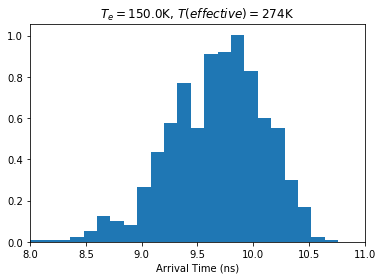

In [101]:
N = 1000
T = 150.0 # Kelvin
dt = 1.0e-11 #s
t_max = 250.0e-9 # maximum time duration of the simulation
FWHM = 100.0e-6
bins = np.linspace(8, 11, 26)
result, t_s, x_trajs, y_trajs, t_arrivals = fixedT_sim(N, T, dt, t_max, FWHM)
if (T, FWHM) not in t_arrival_dict:
    t_arrival_dict[(T, FWHM)] = []
t_arrival_dict[(T, FWHM)] += list(t_arrivals) 
# Plotting
omega_trap = 2*np.pi*230.0e6 # Hz
U_avg = 0.5*m*(omega_trap)**2*(FWHM/2.355)**2
T_eff = U_avg/kB + T
plt.hist(t_arrivals*1.0e9, bins=bins, density=True)
plt.xlabel("Arrival Time (ns)")
plt.title("$T_e = {}$K, $T(effective) = {}$K".format(T, round(T_eff)))
plt.xlim(bins[0], bins[-1])

### 300K

(8.0, 11.0)

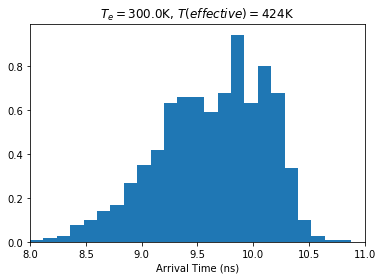

In [102]:
N = 1000
T = 300.0 # Kelvin
dt = 1.0e-11 #s
t_max = 250.0e-9 # maximum time duration of the simulation
FWHM = 100.0e-6
bins = np.linspace(8, 11, 26)
result, t_s, x_trajs, y_trajs, t_arrivals = fixedT_sim(N, T, dt, t_max, FWHM)
if (T, FWHM) not in t_arrival_dict:
    t_arrival_dict[(T, FWHM)] = []
t_arrival_dict[(T, FWHM)] += list(t_arrivals) 
# Plotting
omega_trap = 2*np.pi*230.0e6 # Hz
U_avg = 0.5*m*(omega_trap)**2*(FWHM/2.355)**2
T_eff = U_avg/kB + T
plt.hist(t_arrivals*1.0e9, bins=bins, density=True)
plt.xlabel("Arrival Time (ns)")
plt.title("$T_e = {}$K, $T(effective) = {}$K".format(T, round(T_eff)))
plt.xlim(bins[0], bins[-1])

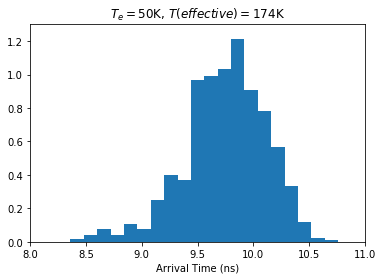

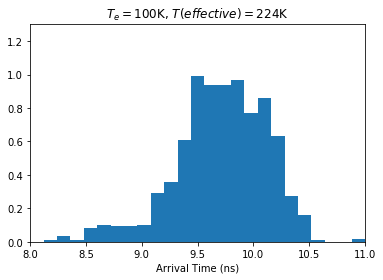

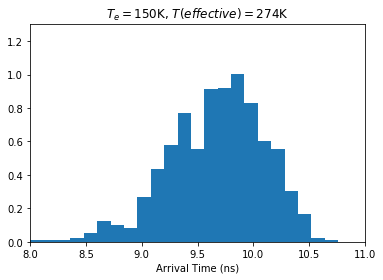

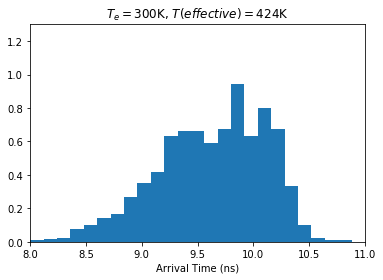

In [103]:
omega_trap = 2*np.pi*230.0e6 # Hz
U_avg = 0.5*m*(omega_trap)**2*(FWHM/2.355)**2
bins = np.linspace(8, 11, 26)
for T in [50, 100, 150, 300]:
    plt.figure()
    T_eff = U_avg/kB + T
    plt.hist(np.array(t_arrival_dict[(T, FWHM)])*1.0e9, bins=bins, density=True)
    plt.xlabel("Arrival Time (ns)")
    plt.title("$T_e = {}$K, $T(effective) = {}$K".format(T, round(T_eff)))
    plt.xlim(bins[0], bins[-1])
    plt.ylim(0, 1.3)
    plt.show()

In [98]:
t_arrival_dict[(300, 100.0e-6)]

[]